<a href="https://colab.research.google.com/github/Hameedhullah/Order-Profit-Prediction/blob/main/Order_Profit_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv("Train.csv")

In [3]:
data_train.head()

,Order ID,Order Date,Country,City,State,Category,Product Name,Quantity,Profit
0,NM-2012-343889,26-04-2015,United States,Lambertfurt,Florida,Furnishings,Table Lamp,3,391.61
1,VA-2022-163003,26-04-2015,United States,West Jennifer,Nevada,Labels,Address Labels,3,579.75
2,KS-2015-985001,26-04-2015,United States,West Melvinborough,Florida,Labels,Address Labels,3,-118.06
3,WI-2014-993323,27-04-2015,United States,Jensenfurt,Florida,Storage,Vertical Stackable Tray,8,854.52
4,MO-2006-118786,27-04-2015,United States,West Adam,California,Accessories,Inkjet Printer Ink,6,167.34


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22291 entries, 0 to 22290
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      22291 non-null  object 
 1   Order Date    22291 non-null  object 
 2   Country       22291 non-null  object 
 3   City          22291 non-null  object 
 4   State         22291 non-null  object 
 5   Category      22291 non-null  object 
 6   Product Name  22291 non-null  object 
 7   Quantity      22291 non-null  int64  
 8   Profit        22291 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.5+ MB


In [21]:
data_train['Order Date'] = pd.to_datetime(data_train['Order Date'])

# Extract time components
data_train['Year'] = data_train['Order Date'].dt.year
data_train['Month'] = data_train['Order Date'].dt.month_name()
data_train['MonthNum'] = data_train['Order Date'].dt.month
data_train['Quarter'] = data_train['Order Date'].dt.quarter
data_train['DayOfWeek'] = data_train['Order Date'].dt.day_name()

In [22]:
data_train.isna().sum()

,0
Order ID,0
Order Date,0
Country,0
City,0
State,0
Category,0
Product Name,0
Quantity,0
Profit,0
Year,0


In [6]:
data_train.duplicated().sum()

np.int64(0)

In [7]:
data_train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Order ID,22291,22291,NV-2008-738206,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order Date,22291,3615,30-10-2019,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,22291,1,United States,22291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,22291,14417,Port Michael,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,22291,10,Ohio,2283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,22291,5,Storage,4637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product Name,22291,15,Mobile Pedestal,1586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,22291.0,NaN,NaN,NaN,5.518101,2.865486,1.0,3.0,6.0,8.0,10.0
Profit,22291.0,NaN,NaN,NaN,398.797705,345.353033,-199.89,99.45,396.44,696.15,999.97


In [27]:
data_train.drop('Order Date',axis=1,inplace=True)

In [28]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22291 entries, 0 to 22290
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      22291 non-null  object 
 1   Country       22291 non-null  object 
 2   City          22291 non-null  object 
 3   State         22291 non-null  object 
 4   Category      22291 non-null  object 
 5   Product Name  22291 non-null  object 
 6   Quantity      22291 non-null  int64  
 7   Profit        22291 non-null  float64
 8   Year          22291 non-null  int32  
 9   Month         22291 non-null  object 
 10  MonthNum      22291 non-null  int32  
 11  Quarter       22291 non-null  int32  
 12  DayOfWeek     22291 non-null  object 
dtypes: float64(1), int32(3), int64(1), object(8)
memory usage: 2.0+ MB


In [9]:
data_less_than_zero = data_train.loc[data_train['Profit'] < 0]

In [10]:
data_less_than_zero

,Order ID,Order Date,Country,City,State,Category,Product Name,Quantity,Profit
2,KS-2015-985001,26-04-2015,United States,West Melvinborough,Florida,Labels,Address Labels,3,-118.06
8,IA-2018-124785,27-04-2015,United States,Smithborough,California,Labels,Color Coding Labels,5,-95.11
12,KS-2001-255768,29-04-2015,United States,Tammymouth,Idaho,Accessories,Inkjet Printer Ink,9,-73.92
15,NC-2003-260265,29-04-2015,United States,Natashaport,New York,Furnishings,Table Lamp,7,-123.77
18,NJ-2025-907346,29-04-2015,United States,Lake Alexis,New York,Copiers,Xerox 3000,4,-149.39
...,...,...,...,...,...,...,...,...,...
22257,SD-2017-757648,16-03-2025,United States,Port Danland,Washington,Copiers,Canon ImageRunner,8,-97.64
22259,MT-2004-701666,16-03-2025,United States,South Veronica,Ohio,Labels,Shipping Labels,5,-45.23
22266,DC-2020-298494,18-03-2025,United States,Huntside,Texas,Copiers,Xerox 3000,3,-150.04
22279,SC-2008-342550,20-03-2025,United States,Freyfort,Illinois,Furnishings,Standing Desk,10,-62.87


In [11]:
profit_skew = data_train['Profit'].skew()
print("Skewness of Profit:", round(profit_skew,4))

Skewness of Profit: 0.0039


In [12]:
print("Unique values per column")
data_train.nunique().sort_values(ascending = True)

Unique values per column


,0
Country,1
Category,5
State,10
Quantity,10
Product Name,15
Order Date,3615
City,14417
Order ID,22291
Profit,22291


In [13]:
for i in data_train.columns:
    print(f"Unique value in {i}")
    print(data_train[i].unique() , '\n')

Unique value in Order ID
['NM-2012-343889' 'VA-2022-163003' 'KS-2015-985001' ... 'LA-2001-826832'
 'GA-2021-314162' 'NV-2008-738206'] 

Unique value in Order Date
['26-04-2015' '27-04-2015' '28-04-2015' ... '20-03-2025' '21-03-2025'
 '22-03-2025'] 

Unique value in Country
['United States'] 

Unique value in City
['Lambertfurt' 'West Jennifer' 'West Melvinborough' ... 'Victorburgh'
 'Cochranshire' 'Nicholashaven'] 

Unique value in State
['Florida' 'Nevada' 'California' 'Ohio' 'Washington' 'Idaho' 'Georgia'
 'New York' 'Illinois' 'Texas'] 

Unique value in Category
['Furnishings' 'Labels' 'Storage' 'Accessories' 'Copiers'] 

Unique value in Product Name
['Table Lamp' 'Address Labels' 'Vertical Stackable Tray'
 'Inkjet Printer Ink' 'Canon ImageRunner' 'HP LaserJet Pro'
 'Color Coding Labels' 'Shipping Labels' 'Office Chair' 'Standing Desk'
 'Steel Filing Cabinet' 'Xerox 3000' 'Mobile Pedestal' 'Calculator'
 'Stapler'] 

Unique value in Quantity
[ 3  8  6  4  5  7  9  2 10  1] 

Unique v

In [20]:
data_train[['Quantity','Profit']].corr()

,Quantity,Profit
Quantity,1.000000,-0.002576
Profit,-0.002576,1.000000


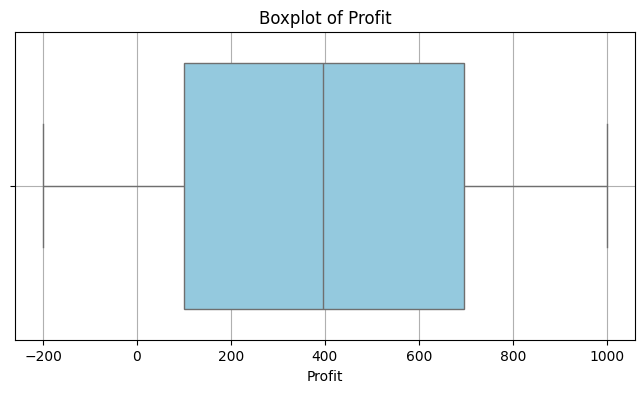

In [14]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=data_train['Profit'], color='skyblue')
plt.title('Boxplot of Profit')
plt.xlabel('Profit')
plt.grid(True)
plt.show()

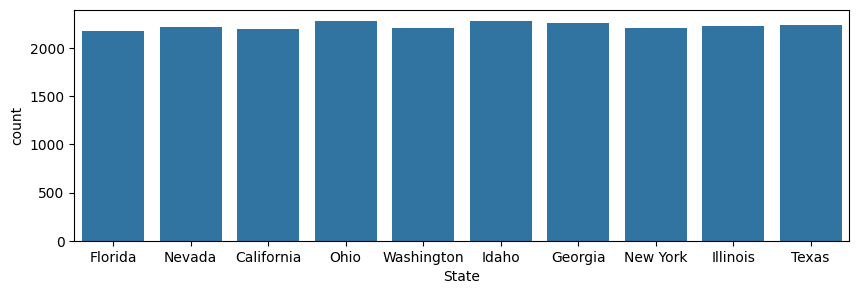

In [15]:
plt.figure(figsize = (10,3))
sns.countplot(data=data_train, x='State')
plt.show()

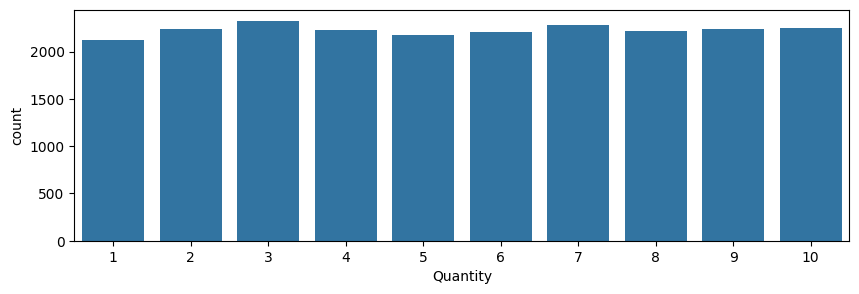

In [16]:
plt.figure(figsize = (10,3))
sns.countplot(data=data_train, x='Quantity')
plt.show()

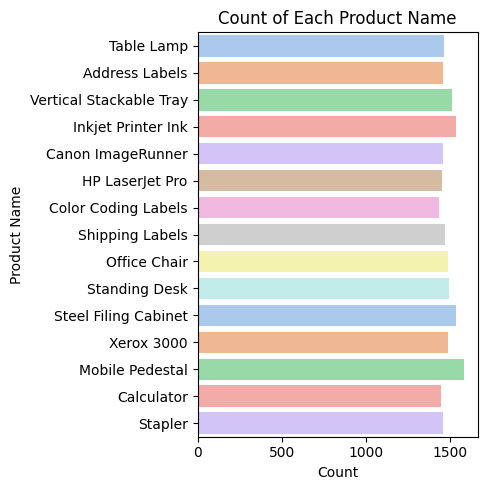

In [17]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data_train, y='Product Name', palette='pastel')
plt.title('Count of Each Product Name')
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()